In [113]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler

DATA_PATH = "./spotify_churn_dataset.csv"

In [114]:
# 1) Load data
df = pd.read_csv(DATA_PATH)

target_col = df["is_churned"]

if "user_id" in df.columns:
  df = df.drop(columns=["user_id", "is_churned"])

In [115]:
# Initial EDA
print('# Dataset Information: ')
df.info()

# Dataset Information: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 8000 non-null   object 
 1   age                    8000 non-null   int64  
 2   country                8000 non-null   object 
 3   subscription_type      8000 non-null   object 
 4   listening_time         8000 non-null   int64  
 5   songs_played_per_day   8000 non-null   int64  
 6   skip_rate              8000 non-null   float64
 7   device_type            8000 non-null   object 
 8   ads_listened_per_week  8000 non-null   int64  
 9   offline_listening      8000 non-null   int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 625.1+ KB


In [116]:
print("# Summary Statistics of Numeric Columns:")
print(df.describe())

# Summary Statistics of Numeric Columns:
               age  listening_time  songs_played_per_day    skip_rate  \
count  8000.000000     8000.000000           8000.000000  8000.000000   
mean     37.662125      154.068250             50.127250     0.300127   
std      12.740359       84.015596             28.449762     0.173594   
min      16.000000       10.000000              1.000000     0.000000   
25%      26.000000       81.000000             25.000000     0.150000   
50%      38.000000      154.000000             50.000000     0.300000   
75%      49.000000      227.000000             75.000000     0.450000   
max      59.000000      299.000000             99.000000     0.600000   

       ads_listened_per_week  offline_listening  
count            8000.000000        8000.000000  
mean                6.943875           0.747750  
std                13.617953           0.434331  
min                 0.000000           0.000000  
25%                 0.000000           0.000000  
5

In [117]:
print("# Missing values in each column:")
print(df.isnull().sum())
print("\n# Duplicate values in the dataset:")
print(df.duplicated().sum())

# Missing values in each column:
gender                   0
age                      0
country                  0
subscription_type        0
listening_time           0
songs_played_per_day     0
skip_rate                0
device_type              0
ads_listened_per_week    0
offline_listening        0
dtype: int64

# Duplicate values in the dataset:
0


In [118]:
print("# Unique values in the dataset:")
print(df.nunique())

# Unique values in the dataset:
gender                     3
age                       44
country                    8
subscription_type          4
listening_time           290
songs_played_per_day      99
skip_rate                 61
device_type                3
ads_listened_per_week     46
offline_listening          2
dtype: int64


In [119]:
numeric_label = ['listening_time','ads_listened_per_week','skip_rate','songs_played_per_day','age']
numeric_cols = [c for c in numeric_label if c in df.columns]

medians = df[numeric_cols].median()
ads_median = medians.get("ads_listened_per_week", 0)
listening_q1 = df["listening_time"].quantile(0.25) if "listening_time" in df.columns else 0

skip_edges = [0.0, 0.3, 0.6, 1.0]
skip_labels = ['low_skip','medium_skip','high_skip']

age_bins = [-1, 20, 30, 45, 200]
age_labels = ['teen','young_adult','adult','senior']

In [120]:
# helper for applying feature engineering
def apply_feature_engineering(df_in, medians, ads_median_val, listening_q1_val):
  df_fe = df_in.copy()

  # Impute numeric: use medians computed from train
  for c in numeric_cols:
    if c in df_fe.columns:
      df_fe[c] = df_fe[c].fillna(medians[c])

  # engagement_score (simple sum + skip influence)
  if all(x in df_fe.columns for x in ['listening_time','songs_played_per_day', 'skip_rate']):
    df_fe['engagement_score'] = (
      df_fe['listening_time'].astype(float)
      + df_fe['songs_played_per_day'].astype(float)
      + (1 - df_fe['skip_rate'].astype(float)) * 10
    )
  else:
    # fallback zero if not all columns are present
    df_fe['engagement_score'] = 0.0

  # is_ad_heavy
  if 'ads_listened_per_week' in df_fe.columns:
    df_fe['is_ad_heavy'] = (df_fe['ads_listened_per_week'].astype(float) > ads_median_val).astype(int)
  else:
    df_fe['is_ad_heavy'] = 0

  # low_activity
  if 'listening_time' in df_fe.columns:
    df_fe['low_activity'] = (df_fe['listening_time'].astype(float) < listening_q1_val).astype(int)
  else:
    df_fe['low_activity'] = 0

  # skip_rate_bucket
  if 'skip_rate' in df_fe.columns:
    df_fe['skip_rate_bucket'] = pd.cut(df_fe['skip_rate'].astype(float), bins=skip_edges, labels=skip_labels, include_lowest=True).astype(str)
  else:
    df_fe['skip_rate_bucket'] = 'unknown'

  # is_premium_like
  if 'subscription_type' in df_fe.columns:
    df_fe['is_premium_like'] = df_fe['subscription_type'].isin(['Premium', 'Family', 'Student']).astype(int)
  else:
    df_fe['is_premium_like'] = 0

  # age_group
  if 'age' in df_fe.columns:
    df_fe['age_group'] = pd.cut(df_fe['age'].astype(float), bins=age_bins, labels=age_labels, include_lowest=True).astype(str)
  else:
    df_fe['age_group'] = 'unknown'

  # engagement_offline_interaction
  if 'offline_listening' in df_fe.columns:
    df_fe['engagement_offline_interaction'] = df_fe['engagement_score'] * df_fe['offline_listening'].astype(float)
  else:
    df_fe['engagement_offline_interaction'] = 0.0
  
  return df_fe

In [122]:
# apply FE to dataset
df_fe = apply_feature_engineering(df, medians, ads_median, listening_q1)
df_fe.head()

,gender,age,country,subscription_type,listening_time,songs_played_per_day,skip_rate,device_type,ads_listened_per_week,offline_listening,engagement_score,is_ad_heavy,low_activity,skip_rate_bucket,is_premium_like,age_group,engagement_offline_interaction
0,Female,54,CA,Free,26,23,0.20,Desktop,31,0,57.0,1,1,low_skip,0,senior,0.0
1,Other,33,DE,Family,141,62,0.34,Web,0,1,209.6,0,0,medium_skip,1,adult,209.6
2,Male,38,AU,Premium,199,38,0.04,Mobile,0,1,246.6,0,0,low_skip,1,adult,246.6
3,Female,22,CA,Student,36,2,0.31,Mobile,0,1,44.9,0,1,medium_skip,1,young_adult,44.9
4,Other,29,US,Family,250,57,0.36,Mobile,0,1,313.4,0,0,medium_skip,1,young_adult,313.4


In [ ]:
# apply onehot encode
bool_cols = df_fe.select_dtypes(include=['bool']).columns
df_fe[bool_cols] = df_fe[bool_cols].astype(int)

numeric_cols = df_fe.select_dtypes(
  include=['int64', 'float64']).columns.tolist()
categorical_cols = df_fe.select_dtypes(
  include=['object', 'category']).columns.tolist()

numeric_cols = sorted(numeric_cols)
categorical_cols = sorted(categorical_cols)

try:
  onehotencode = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
  onehotencode = OneHotEncoder(handle_unknown='ignore', sparse=False)

numeric_transformer = Pipeline(steps=[
  ('imputer', SimpleImputer(strategy='median')),
  ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
  ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
  ("onehot", onehotencode)
])

preprocessor_fe = ColumnTransformer(
  transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
  ],
  remainder='drop',
  sparse_threshold=0
)

preprocessor_fe.fit(df_fe)
df_fe_processor = preprocessor_fe.transform(df_fe)

feat_num = numeric_cols
try:
  feat_cat = preprocessor_fe.named_transformers_[
    'cat']['onehot'].get_feature_names_out(categorical_cols)
  feat_cat = list(feat_cat)
except:
  feat_cat = []
  for col in categorical_cols:
    uniques = df_fe[col].fillna('Unknown').unique().tolist()
    for u in uniques:
      feat_cat.append(f"{col}_{u}")
feature_names = list(feat_num) + list(feat_cat)

df_fe_finale = pd.DataFrame(df_fe_processor, columns=feature_names)
df_fe_finale["is_churned"] = target_col.values
df_fe_finale.head()

# save FE processed to CSVs
df_fe_finale.to_csv("./preprocessed_feature_construction.csv", index=False)

In [ ]:
joblib.dump(
    preprocessor_fe,
    "preprocess_rfc_feature_construction.joblib"
)

['preprocess_rfc_feature_construction.joblib']

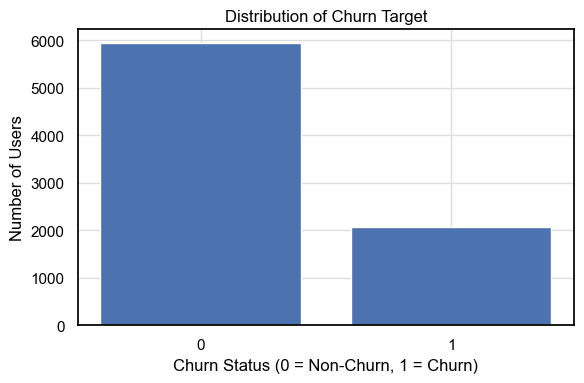

# Churn Ratio:
is_churned
0    0.741125
1    0.258875
Name: count, dtype: float64


,count,proportion
is_churned,,
0,5929,0.741125
1,2071,0.258875


In [125]:
# Target distribution
target_counts = df_fe_finale['is_churned'].value_counts().sort_index()

plt.figure(figsize=(6, 4))
plt.bar(
  target_counts.index.astype(str),
  target_counts.values
)
plt.xlabel("Churn Status (0 = Non-Churn, 1 = Churn)")
plt.ylabel("Number of Users")
plt.title("Distribution of Churn Target")
plt.tight_layout()
plt.show()

# Tampilkan proporsi
target_ratio = target_counts / target_counts.sum()
print("# Churn Ratio:")
print(target_ratio)
pd.DataFrame({
  "count": target_counts,
  "proportion": target_ratio
})

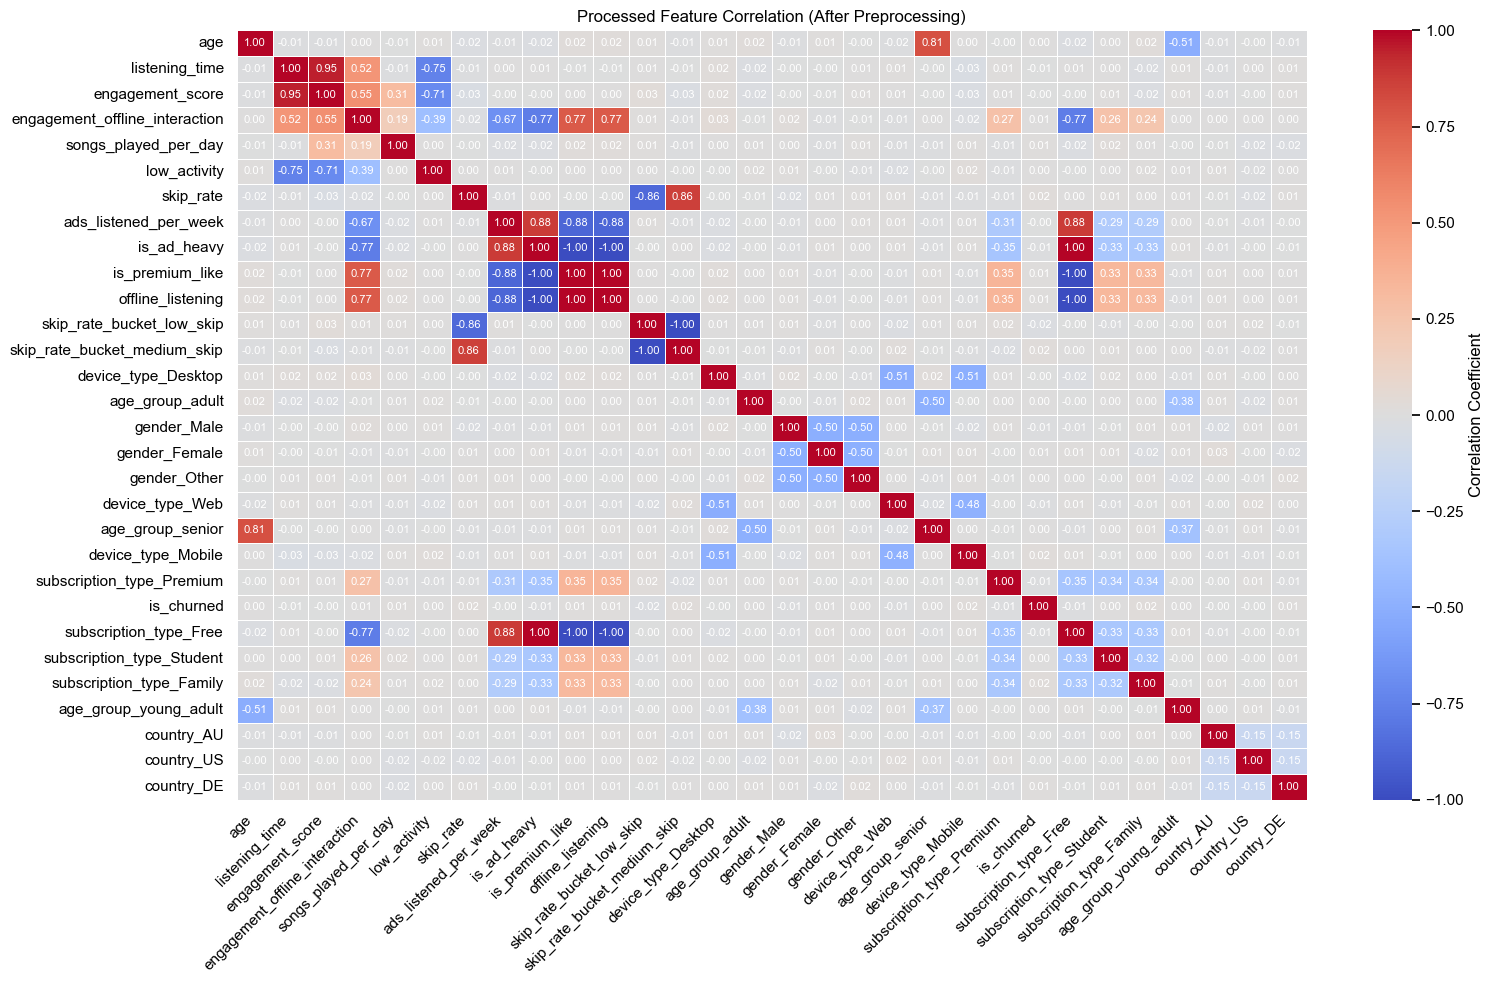

In [126]:
def set_plot_theme(mode="dark"):
  """
  mode: 'dark' or 'light'
  """
  if mode == "dark":
    sns.set_theme(
      style="dark",
      rc={
        "figure.facecolor": "#1f1f1f",
        "axes.facecolor": "#1f1f1f",
        "axes.edgecolor": "white",
        "axes.labelcolor": "white",
        "text.color": "white",
        "xtick.color": "white",
        "ytick.color": "white",
        "grid.color": "#444444",
        "figure.autolayout": True
      }
    )
  elif mode == "light":
    sns.set_theme(
      style="whitegrid",
      rc={
        "figure.facecolor": "white",
        "axes.facecolor": "white",
        "axes.edgecolor": "black",
        "axes.labelcolor": "black",
        "text.color": "black",
        "xtick.color": "black",
        "ytick.color": "black",
        "grid.color": "#DDDDDD",
        "figure.autolayout": True
      }
    )
  else:
    raise ValueError("mode must be 'dark' or 'light'")
  
set_plot_theme("light")

top_k = 30
variances = df_fe_finale.var().abs().sort_values(ascending=False)
top_features = variances.head(top_k).index.tolist()
corr_proc_sub = df_fe_finale[top_features].corr()

plt.figure(figsize=(16, 10))
ax = sns.heatmap(
  corr_proc_sub,
  cmap="coolwarm",
  annot=True,
  fmt=".2f",
  annot_kws={"fontsize": 8, "color": "white"},
  linewidths=0.5,
  cbar_kws={"label": "Correlation Coefficient"}
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_title("Processed Feature Correlation (After Preprocessing)")
plt.tight_layout()
plt.show()